In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
import matplotlib.patches
import wqchartpy
import datetime
import olm
import scipy

print("Package versions: ")
print("Matplotlib: ",matplotlib.__version__)
print("NumPy: ", np.__version__)
print("Pandas: ",pd.__version__)
print("WQChartPy: 0.1.10")
#print("datetime
print("olm: 0.39")


Package versions: 
Matplotlib:  3.8.0
NumPy:  1.25.2
Pandas:  1.5.3
WQChartPy: 0.1.10
olm: 0.39


# Part 1: Dataset Formatting

### 1a. Read in the MasterWaterQuality.CSV file containing all the data from a weekly samplign field campaign form 2021-2022


Note that this file contains data not used in this analysis. We will only be using the data from Lake Jackson (labeled as "Porter Sink" here), the FSU Well, and Wakulla Springs.

In [2]:
wq_df = pd.read_csv('../data/raw_data/MasterWaterQuality.csv', parse_dates=['Sampling time'],
                    index_col='Sampling time')
wq_df

,ID,Location,dD vs vsmow,d18O vs vsmow,Lithium,Sodium,Ammonium,Potassium,Magnesium,Calcium,...,Bromide,Nitrate,Phosphate,Sulfate,pH,pOH,Total Alkalinity (mg/L as CaCO3),Bicarbonate,EC(us/cm),color
Sampling time,,,,,,,,,,,,,,,,,,,,,
2021-05-04 13:00:00,LJ000,Porter Sink,15.0,3.48,0.0,2.440,0.0,1.077,1.812,3.560,...,0.0,0.1223,0.0,0.0,6.52,7.48,13.8,16.836,52.1,k
2021-06-07 13:49:00,LJ001,Porter Sink,25.9,6.29,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.11,8.89,2.8,3.416,44.5,k
2021-06-08 13:08:00,LJ002,Porter Sink,23.3,5.29,0.0,1.818,0.0,0.949,0.966,2.393,...,0.0,0.2130,0.0,0.0,6.55,7.45,6.0,7.320,32.0,k
2021-06-14 17:20:00,LJ003,Porter Sink,29.4,6.43,0.0,2.275,0.0,0.733,1.023,2.460,...,0.0,0.1929,0.0,0.0,5.99,8.01,7.2,8.784,35.0,k
2021-06-21 11:18:00,LJ004,Porter Sink,5.1,3.20,0.0,2.439,0.0,0.778,1.197,2.656,...,0.0,0.0000,0.0,0.0,6.31,7.69,9.8,11.956,38.0,k
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-23 13:50:00,PRE001,Rain,-26.6,-4.25,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y
2021-07-05 15:39:00,PRE002,Rain,-50.6,-7.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y
2021-07-18 13:15:00,PRE003,Rain,-5.8,-2.93,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.2019,0.0,0.0,NaN,NaN,NaN,NaN,NaN,y


### 1b. Use the OLM package from the Covington Lab of University of Arkansas to calculate a more accurate Bicarbonate using the Alkalinity value output from our titrator

In [3]:
###Accurate Bicarbonate Calculation OLM Package and USGS procedure
## ALL IN MG/L FROM USGS SOURCE https://or.water.usgs.gov/alk/methods.html#advanced
from olm.calcite import calc_K_2

#Function to convert Alkalinity as mg/L CaCO3 to meq/L
def alk_mgLCaCo3_to_meqL(alk_mgL):
    alk_meqL=alk_mgL/(1/2)/(100.087)
    return alk_meqL

## Second dissociation constant needed for speciation
K2=calc_K_2(298.15)

# ALL IN MG/L FROM USGS SOURCE https://or.water.usgs.gov/alk/methods.html#advanced
## The calculations mostly use meq/l but they are reconverted to mg/L as an output to keep units consistent in the dataframe

wq_df['H']=((10**-wq_df['pH'])*1.00784*1000).round(4)
wq_df["OH"]=((1E-14*(10**wq_df["pH"])*17007.3)).round(4)
wq_df["CO3"]=((((alk_mgLCaCo3_to_meqL(wq_df["Total Alkalinity (mg/L as CaCO3)"])/1000)-(wq_df['OH']/17007.3)+10**-wq_df['pH'])/(2+(10**-wq_df['pH']/K2)))*60009.2).round(4)

wq_df["HCO3"]=((((alk_mgLCaCo3_to_meqL(wq_df["Total Alkalinity (mg/L as CaCO3)"])/1000)-(wq_df['OH']/17007.3)+10**-wq_df['pH'])/(1+(2*K2*10**wq_df['pH'])))*61017.1).round(4)

wq_df['Location']=wq_df["Location"].str.replace("Porter Sink", "Lake Jackson")

wq_df

,ID,Location,dD vs vsmow,d18O vs vsmow,Lithium,Sodium,Ammonium,Potassium,Magnesium,Calcium,...,pH,pOH,Total Alkalinity (mg/L as CaCO3),Bicarbonate,EC(us/cm),color,H,OH,CO3,HCO3
Sampling time,,,,,,,,,,,,,,,,,,,,,
2021-05-04 13:00:00,LJ000,Lake Jackson,15.0,3.48,0.0,2.440,0.0,1.077,1.812,3.560,...,6.52,7.48,13.8,16.836,52.1,k,0.0003,0.0006,0.0026,16.8371
2021-06-07 13:49:00,LJ001,Lake Jackson,25.9,6.29,NaN,NaN,NaN,NaN,NaN,NaN,...,5.11,8.89,2.8,3.416,44.5,k,0.0078,0.0000,0.0000,3.8876
2021-06-08 13:08:00,LJ002,Lake Jackson,23.3,5.29,0.0,1.818,0.0,0.949,0.966,2.393,...,6.55,7.45,6.0,7.320,32.0,k,0.0003,0.0006,0.0012,7.3283
2021-06-14 17:20:00,LJ003,Lake Jackson,29.4,6.43,0.0,2.275,0.0,0.733,1.023,2.460,...,5.99,8.01,7.2,8.784,35.0,k,0.0010,0.0002,0.0004,8.8397
2021-06-21 11:18:00,LJ004,Lake Jackson,5.1,3.20,0.0,2.439,0.0,0.778,1.197,2.656,...,6.31,7.69,9.8,11.956,38.0,k,0.0005,0.0003,0.0011,11.9755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-23 13:50:00,PRE001,Rain,-26.6,-4.25,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,y,NaN,NaN,NaN,NaN
2021-07-05 15:39:00,PRE002,Rain,-50.6,-7.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,y,NaN,NaN,NaN,NaN
2021-07-18 13:15:00,PRE003,Rain,-5.8,-2.93,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,y,NaN,NaN,NaN,NaN


### 1c. Make a copy of the full data set that is formatted in mg/L and presents only the sites used in this study

In [4]:
format_df = pd.DataFrame()

format_df['ID'] = wq_df['ID']
format_df['Sampling time'] = wq_df.index
format_df['Location']=wq_df['Location']

#PhysioChemistry
format_df['pH'] = wq_df['pH']
format_df['pOH'] = wq_df['pOH']
format_df['EC(us/cm)'] = wq_df['EC(us/cm)']

#Cations
#format_df['Li_mgL'] = wq_df['Lithium']
format_df['Na_mgL'] = wq_df['Sodium'] 
#format_df['NH4_mgL'] = wq_df['Ammonium'] 
format_df['K_mgL'] = wq_df['Potassium'] 
format_df['Mg_mgL'] = wq_df['Magnesium']
format_df['Ca_mgL'] = wq_df['Calcium']           

#Anions
format_df['F_mgL'] = wq_df['Fluoride']
format_df['Cl_mgL'] = wq_df['Chloride']
#format_df['NO2_mgL'] = wq_df['Nitrite']
#format_df['Br_mgL'] = wq_df['Bromide']
format_df['NO3_mgL'] = wq_df['Nitrate']
format_df['PO4_mgL'] = wq_df['Phosphate']
format_df['SO4_mgL'] = wq_df['Sulfate'].values
format_df['HCO3_mgL'] = wq_df['HCO3']
format_df['CO3_mgL']= wq_df['CO3']
format_df =  format_df[format_df['Location'].isin(['Lake Jackson ', 'FSU Well', 'Wakulla Springs'])]
format_df=format_df.dropna()
format_df.reset_index(drop=True, inplace=True)

format_df.to_csv("../data/processed/Formatted_2021_mgL.CSV", na_rep="NaN")

In [5]:
format_df

,ID,Sampling time,Location,pH,pOH,EC(us/cm),Na_mgL,K_mgL,Mg_mgL,Ca_mgL,F_mgL,Cl_mgL,NO3_mgL,PO4_mgL,SO4_mgL,HCO3_mgL,CO3_mgL
0,LJ000,2021-05-04 13:00:00,Lake Jackson,6.520,7.480,52.1,2.440,1.077,1.812,3.560,0.1552,5.9191,0.1223,0.0,0.0000,16.8371,0.0026
1,LJ002,2021-06-08 13:08:00,Lake Jackson,6.550,7.450,32.0,1.818,0.949,0.966,2.393,0.1882,4.6700,0.2130,0.0,0.0000,7.3283,0.0012
2,LJ003,2021-06-14 17:20:00,Lake Jackson,5.990,8.010,35.0,2.275,0.733,1.023,2.460,0.0517,3.8784,0.1929,0.0,0.0000,8.8397,0.0004
3,LJ004,2021-06-21 11:18:00,Lake Jackson,6.310,7.690,38.0,2.439,0.778,1.197,2.656,0.0557,3.8762,0.0000,0.0,0.0000,11.9755,0.0011
4,LJ005,2021-06-25 10:40:00,Lake Jackson,6.120,7.880,59.5,4.056,2.849,1.543,3.499,0.0000,5.0591,0.0000,0.0,0.0000,13.3341,0.0008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,WS021,2021-09-16 09:15:00,Wakulla Springs,7.490,6.510,305.0,5.250,0.627,9.562,46.775,0.0000,3.7756,0.6175,0.0,6.2653,166.6633,0.2375
72,WS022,2021-09-30 08:55:00,Wakulla Springs,7.370,6.630,293.0,5.086,0.550,9.294,43.847,0.0888,7.1763,1.5440,0.0,9.9069,159.3637,0.1723
73,WS023,2021-10-07 09:40:00,Wakulla Springs,7.980,6.020,299.0,5.141,0.558,9.189,45.501,0.0000,7.2922,1.4046,0.0,10.7847,166.2267,0.7322
74,WS024,2021-10-14 09:30:00,Wakulla Springs,7.485,6.515,291.0,4.705,0.642,9.435,44.493,0.1514,6.0072,1.1445,0.0,8.0690,161.1981,0.2271


### 1d. Save this weekly sampling data in a format that is readable by WQChartPy for plotting

In [6]:
### Creating a df with special formatting to make it compatible with WQChartPy
WQChartPy_df = pd.DataFrame()

WQChartPy_df['Sample'] = wq_df['ID']
WQChartPy_df['Label'] = wq_df['Location']
WQChartPy_df['Color']=wq_df['color']
WQChartPy_df['Marker']='o'
WQChartPy_df.loc[WQChartPy_df['Label']== "FSU Well", 'Marker'] = 's'
WQChartPy_df.loc[WQChartPy_df['Label']== "Wakulla Springs", 'Color'] = 'b'
WQChartPy_df['Size']=30
WQChartPy_df['Alpha']=0.9
WQChartPy_df['pH'] = wq_df['pH']
WQChartPy_df['Ca'] = wq_df['Calcium']
WQChartPy_df['Mg'] = wq_df['Magnesium']
WQChartPy_df['Na'] = wq_df['Sodium']              
WQChartPy_df['K'] = wq_df['Potassium']   
WQChartPy_df['HCO3'] = wq_df['HCO3']
WQChartPy_df['Cl'] = wq_df['Chloride']
WQChartPy_df['CO3']= wq_df['CO3']
WQChartPy_df['SO4'] = wq_df['Sulfate'].values
WQChartPy_df['TDS'] = wq_df['EC(us/cm)']*0.7
#format_df['Day']= wq_df['Sampling time'].dt.dayofyear-124
WQChartPy_df['Label']=WQChartPy_df["Label"].str.replace("Porter Sink", "Lake Jackson")

WQChartPy_df=WQChartPy_df.dropna()
WQChartPy_df.reset_index(drop=True, inplace=True)
WQChartPy_df
WQChartPy_df.to_csv("../data/processed/WQChartPy_2021_mgL.CSV")


### 1e. Convert this Weekly Dataset to units of meq/L using 

In [7]:
##Values of each element used in calculation

#Cations
Li_mass = 6.94
Li_charge = 1
Na_mass = 22.99
Na_charge = 1
NH4_mass = 14.007 + (4*1.008)
NH4_charge = 1
K_mass = 39.098
K_charge = 1
Mg_mass = 24.305
Mg_charge = 2
Ca_mass = 40.078
Ca_charge = 2

#Anions
F_mass = 18.998
F_charge = -1
Cl_mass = 35.45
Cl_charge = -1
NO2_mass = 14.007 + (2*15.999)
NO2_charge = -1
Br_mass = 79.904
Br_charge = -1
NO3_mass = 14.007 + (3*15.999)
NO3_charge = -1
PO4_mass = 30.974 + (4*15.999)
PO4_charge = -3
SO4_mass = 32.06 + (4*15.999)
SO4_charge = -2
HCO3_mass = 1.008 + 12.011 + (3*15.999)
HCO3_charge = -1
CO3_mass = 12.011 + (3*15.999)
CO3_charge = -2


In [8]:
format_df

,ID,Sampling time,Location,pH,pOH,EC(us/cm),Na_mgL,K_mgL,Mg_mgL,Ca_mgL,F_mgL,Cl_mgL,NO3_mgL,PO4_mgL,SO4_mgL,HCO3_mgL,CO3_mgL
0,LJ000,2021-05-04 13:00:00,Lake Jackson,6.520,7.480,52.1,2.440,1.077,1.812,3.560,0.1552,5.9191,0.1223,0.0,0.0000,16.8371,0.0026
1,LJ002,2021-06-08 13:08:00,Lake Jackson,6.550,7.450,32.0,1.818,0.949,0.966,2.393,0.1882,4.6700,0.2130,0.0,0.0000,7.3283,0.0012
2,LJ003,2021-06-14 17:20:00,Lake Jackson,5.990,8.010,35.0,2.275,0.733,1.023,2.460,0.0517,3.8784,0.1929,0.0,0.0000,8.8397,0.0004
3,LJ004,2021-06-21 11:18:00,Lake Jackson,6.310,7.690,38.0,2.439,0.778,1.197,2.656,0.0557,3.8762,0.0000,0.0,0.0000,11.9755,0.0011
4,LJ005,2021-06-25 10:40:00,Lake Jackson,6.120,7.880,59.5,4.056,2.849,1.543,3.499,0.0000,5.0591,0.0000,0.0,0.0000,13.3341,0.0008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,WS021,2021-09-16 09:15:00,Wakulla Springs,7.490,6.510,305.0,5.250,0.627,9.562,46.775,0.0000,3.7756,0.6175,0.0,6.2653,166.6633,0.2375
72,WS022,2021-09-30 08:55:00,Wakulla Springs,7.370,6.630,293.0,5.086,0.550,9.294,43.847,0.0888,7.1763,1.5440,0.0,9.9069,159.3637,0.1723
73,WS023,2021-10-07 09:40:00,Wakulla Springs,7.980,6.020,299.0,5.141,0.558,9.189,45.501,0.0000,7.2922,1.4046,0.0,10.7847,166.2267,0.7322
74,WS024,2021-10-14 09:30:00,Wakulla Springs,7.485,6.515,291.0,4.705,0.642,9.435,44.493,0.1514,6.0072,1.1445,0.0,8.0690,161.1981,0.2271


In [9]:
#Make a copy of the dataframe to manipulate
weekly_meqL_df = pd.DataFrame()
# Calculate each value based on formula meq/L = [(mg/L) * Charge]/Molar Mass

#ID columns
weekly_meqL_df['ID'] = format_df['ID']
weekly_meqL_df['Sampling time'] = format_df['Sampling time']
weekly_meqL_df['Location'] = format_df['Location']
#Cations
#weekly_meqL_df['Li_meqL'] = format_df['Li_mgL'] * Li_charge / Li_mass
weekly_meqL_df['Na_meqL'] = round((format_df['Na_mgL'] * Na_charge / Na_mass),3)
#weekly_meqL_df['NH4'] = weekly_meqL_df['NH4'] * NH4_charge / NH4_mass
weekly_meqL_df['K_meqL'] = round((format_df['K_mgL'] * K_charge / K_mass),3)
weekly_meqL_df['Mg_meqL'] = round((format_df['Mg_mgL'] * Mg_charge / Mg_mass),3)
weekly_meqL_df['Ca_meqL'] = round((format_df['Ca_mgL'] * Ca_charge / Ca_mass),3)

# Anions 
weekly_meqL_df['F_meqL'] = round((format_df['F_mgL'] * F_charge / F_mass),3)
weekly_meqL_df['Cl_meqL'] = round((format_df['Cl_mgL'] * Cl_charge / Cl_mass),3)
#weekly_meqL_df['NO2'] = weekly_meqL_df['NO2'] * NO2_charge / NO2_mass
#weekly_meqL_df['Br'] = weekly_meqL_df['Br'] * Br_charge / Br_mass
weekly_meqL_df['NO3_meqL'] = round((format_df['NO3_mgL'] * NO3_charge / NO3_mass),3)
weekly_meqL_df['PO4_meqL'] = round((format_df['PO4_mgL'] * PO4_charge / PO4_mass),3)
weekly_meqL_df['SO4_meqL'] = round((format_df['SO4_mgL'] * SO4_charge / SO4_mass),3)
weekly_meqL_df['HCO3_meqL'] = round((format_df['HCO3_mgL'] * HCO3_charge / HCO3_mass),3)
weekly_meqL_df['CO3_meqL'] = round((format_df['CO3_mgL'] * CO3_charge / CO3_mass),3)

# Per Geochemistry, Groundwater and Pollution by Appelo and Postma, Electrical Balance % is calculated
# by the formula Eb% = (Sum Cations + Sum Anions)/(Sum Cations - Sum Anions) *100 where the cations and 
# anions are espressed as meq/L and inserted with their charge sign. The sums are taken over the 
# Cations Na+, K+, Mg2+, and Ca2+, and the anions Cl-, HCO3-, SO42-, and NO3-

weekly_meqL_df["CationSum"] = weekly_meqL_df['Na_meqL'] + weekly_meqL_df['K_meqL'] + weekly_meqL_df['Mg_meqL'] + weekly_meqL_df['Ca_meqL']
weekly_meqL_df['AnionSum'] = weekly_meqL_df['Cl_meqL'] + weekly_meqL_df['HCO3_meqL'] + weekly_meqL_df['SO4_meqL'] + weekly_meqL_df['NO3_meqL'] 
weekly_meqL_df['EB_perc'] = round(((weekly_meqL_df['CationSum'] + weekly_meqL_df["AnionSum"]) / (weekly_meqL_df['CationSum'] - weekly_meqL_df["AnionSum"]) *100), 2)

rows_to_drop = weekly_meqL_df.loc[abs(weekly_meqL_df['EB_perc'])>10]

weekly_meqL_df = weekly_meqL_df.loc[abs(weekly_meqL_df['EB_perc'])<10]
weekly_meqL_df
weekly_meqL_df.to_csv("../data/processed/Full2021_WQ_meq_L.csv", na_rep = "NaN")

In [10]:
drop_rows_list= list(rows_to_drop.ID)
drop_rows_list


['LJ003',
 'LJ005',
 'LJ006',
 'LJ007',
 'LJ009',
 'LJ010',
 'LJ011',
 'LJ012',
 'LJ014',
 'LJ015',
 'LJ016',
 'LJ018',
 'LJ019',
 'LJ022',
 'LJ027',
 'FW003']

### 1f. Load in Dataset of daily sampling at FSU Well and convert it to units of meq/L

In [11]:
daily_mgL_df = pd.read_csv("../data/raw_data/FSUWell_FebMar_WQ_mg_per_L.csv")
daily_mgL_df

###Accurate Bicarbonate Calculation OLM Package and USGS procedure
## ALL IN MG/L FROM USGS SOURCE https://or.water.usgs.gov/alk/methods.html#advanced
from olm.calcite import calc_K_2

def alk_mgLCaCo3_to_meqL(alk_mgL):
    alk_meqL=alk_mgL/(1/2)/(100.087)
    return alk_meqL

# ALL IN MG/L FROM USGS SOURCE https://or.water.usgs.gov/alk/methods.html#advanced
daily_mgL_df['H']=(10**-daily_mgL_df['pH'])*1.00784*1000
daily_mgL_df["OH"]=(1E-14*(10**daily_mgL_df["pH"])*17007.3)
daily_mgL_df["CO3"]=(((alk_mgLCaCo3_to_meqL(daily_mgL_df["TotalAlk(mg/L_asCaCO3)"])/1000)-(daily_mgL_df['OH']/17007.3)+10**-daily_mgL_df['pH'])/(2+(10**-daily_mgL_df['pH']/calc_K_2(daily_mgL_df['Temp']+273.15))))*60009.2

daily_mgL_df["HCO3"]=(((alk_mgLCaCo3_to_meqL(daily_mgL_df["TotalAlk(mg/L_asCaCO3)"])/1000)-(daily_mgL_df['OH']/17007.3)+10**-daily_mgL_df['pH'])/(1+(2*calc_K_2(daily_mgL_df['Temp']+273.15)*10**daily_mgL_df['pH'])))*61017.1

daily_mgL_df.to_csv('../data/processed/FSUWell_FebMar_WQ.csv', na_rep="NaN")
#Make a copy of the dataframe to manipulate
daily_meqL_df = pd.DataFrame()

#Sample data and physiochemistry
daily_meqL_df['ID'] = daily_mgL_df['ID']
daily_meqL_df['Datatime_Collection'] = daily_mgL_df['Datatime_Collection']
daily_meqL_df['pH'] = daily_mgL_df['pH']
daily_meqL_df['EC'] = daily_mgL_df['EC']


# Calculate each value based on formula meq/L = [(mg/L) * Charge]/Molar Mass

#Cations
#daily_meqL_df['Li'] = daily_mgL_df['Li'] * Li_charge / Li_mass
daily_meqL_df['Na_meqL'] = round((daily_mgL_df['Na'] * Na_charge / Na_mass), 3)
daily_meqL_df['NH4'] = round((daily_mgL_df['NH4'] * NH4_charge / NH4_mass),3)
daily_meqL_df['K_meqL'] = round((daily_mgL_df['K'] * K_charge / K_mass),3)
daily_meqL_df['Mg_meqL'] = round((daily_mgL_df['Mg'] * Mg_charge / Mg_mass),3)
daily_meqL_df['Ca_meqL'] = round((daily_mgL_df['Ca'] * Ca_charge / Ca_mass),3)

# Anions 
daily_meqL_df['F_meqL'] = round((daily_mgL_df['F'] * F_charge / F_mass),3)
daily_meqL_df['Cl_meqL'] = round((daily_mgL_df['Cl'] * Cl_charge / Cl_mass),3)
#daily_meqL_df['NO2_meqL'] = daily_mgL_df['NO2'] * NO2_charge / NO2_mass
daily_meqL_df['Br_meqL'] = round((daily_mgL_df['Br'] * Br_charge / Br_mass),3)
daily_meqL_df['NO3_meqL'] = round((daily_mgL_df['NO3'] * NO3_charge / NO3_mass),3)
daily_meqL_df['PO4_meqL'] = round((daily_mgL_df['PO4'] * PO4_charge / PO4_mass),3)
daily_meqL_df['SO4_meqL'] = round((daily_mgL_df['SO4'] * SO4_charge / SO4_mass),3)
daily_meqL_df['HCO3_meqL'] = round((daily_mgL_df['HCO3'] * HCO3_charge / HCO3_mass),3)
daily_meqL_df['CO3_meqL'] = round((daily_mgL_df['CO3'] * CO3_charge / CO3_mass),3)

# Per Geochemistry, Groundwater and Pollution by Appelo and Postma, Electrical Balance % is calculated
# by the formula Eb% = (Sum Cations + Sum Anions)/(Sum Cations - Sum Anions) *100 where the cations and 
# anions are espressed as meq/L and inserted with their charge sign. The sums are taken over the 
# Cations Na+, K+, Mg2+, and Ca2+, and the anions Cl-, HCO3-, SO42-, and NO3-

daily_meqL_df["CationSum"] = daily_meqL_df['Na_meqL'] + daily_meqL_df['K_meqL'] + daily_meqL_df['Mg_meqL'] + daily_meqL_df['Ca_meqL']
daily_meqL_df['AnionSum'] = daily_meqL_df['Cl_meqL'] + daily_meqL_df['HCO3_meqL'] + daily_meqL_df['SO4_meqL'] + daily_meqL_df['NO3_meqL']

daily_meqL_df['EB_perc'] = round(((daily_meqL_df['CationSum'] + daily_meqL_df["AnionSum"]) / (daily_meqL_df['CationSum'] - daily_meqL_df["AnionSum"]) *100),2)

print(daily_meqL_df['EB_perc'])
daily_meqL_df.to_csv('../data/processed/FSUWell_FebMar_meqL.csv', na_rep="NaN")

0     17.41
1     17.27
2     18.24
3     18.53
4     19.03
5     19.33
6     17.05
7     25.73
8     19.96
9     17.32
10    19.84
11    17.91
12    23.31
13    18.01
14    17.98
15    18.05
16    18.10
17    10.03
18    -0.65
19    18.82
20    13.99
21    20.49
22    17.03
23    18.06
24    11.02
25    22.47
26    18.10
27    18.15
28    17.73
29    18.28
30    17.82
31    18.73
32    18.61
33    18.62
34    17.92
35    21.58
36    23.46
37    21.34
Name: EB_perc, dtype: float64


# 2. Make Plots 

In [12]:
## LOAD In Precipitation Data
precip2021=pd.read_csv("../data/raw_data/Precipitation_2021DryDowns.CSV", parse_dates=['Date'])
precip2021

,COOPID,YEAR,MONTH,DAY,precipitation,Date
0,88758,2021,6,1,0.0,2021-06-01
1,88758,2021,6,2,0.0,2021-06-02
2,88758,2021,6,3,0.0,2021-06-03
3,88758,2021,6,4,0.0,2021-06-04
4,88758,2021,6,5,0.0,2021-06-05
...,...,...,...,...,...,...
164,88758,2021,11,12,0.0,2021-11-12
165,88758,2021,11,13,0.0,2021-11-13
166,88758,2021,11,14,0.0,2021-11-14
167,88758,2021,11,15,0.0,2021-11-15


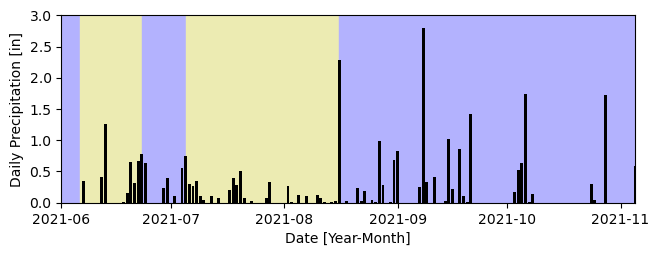

In [13]:
fig, ax = plt.subplots(1,1, figsize=(7,3))
fig.tight_layout(pad=3.0)

wet1= matplotlib.patches.Rectangle((18778,0), 6, 3, color='#b3b2fe')
dry1 = matplotlib.patches.Rectangle((18784,0), 17, 3, color='#ecebb2')
wet2= matplotlib.patches.Rectangle((18801,0), 12, 3, color='#b3b2fe')
dry2 = matplotlib.patches.Rectangle((18813,0), 42, 3, color='#ecebb2')
wet3= matplotlib.patches.Rectangle((18855,0), 82, 3, color='#b3b2fe')
ax.add_patch(wet1)
ax.add_patch(dry1)
ax.add_patch(wet2)
ax.add_patch(dry2)
ax.add_patch(wet3)
ax.bar(precip2021.Date, precip2021['precipitation'], color='k')
ax.set_xlim(left=datetime.date(2021,6,1), right=datetime.date(2021,11,5))
ax.set_ylim(bottom=0, top=3)
ax.set_ylabel("Daily Precipitation [in]")
ax.set_xlabel("Date [Year-Month]")
fig.savefig("../plots/2021_DD_Precip.JPG", dpi=300, format='jpg')
fig.savefig("../plots/2021_DD_Precip.EPS", dpi=300, format='eps')

In [14]:
drop_rows_list


['LJ003',
 'LJ005',
 'LJ006',
 'LJ007',
 'LJ009',
 'LJ010',
 'LJ011',
 'LJ012',
 'LJ014',
 'LJ015',
 'LJ016',
 'LJ018',
 'LJ019',
 'LJ022',
 'LJ027',
 'FW003']

# Plotting Timesereis of Individual Ions

In [15]:
## SPLIT THE SAMPLE SITES INTO DIFFERENT DATAFRAMES
## Subsetting WQ_DF because it cotains datetime information
wq_df = pd.read_csv("../data/processed/Full2021_WQ_meq_L.csv", parse_dates=['Sampling time'],
                    index_col='Sampling time')
LJ=wq_df.loc[wq_df['Location'] == 'Lake Jackson ']
LJ=LJ.drop(LJ[LJ.ID.isin(drop_rows_list)].index.tolist())

FW=wq_df.loc[wq_df['Location'] == 'FSU Well']
WS=wq_df.loc[wq_df['Location'] == 'Wakulla Springs']
#LJ=LJ.drop('2021-05-04 13:00:00')
#FW=FW.drop('2021-05-04 12:45:00')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


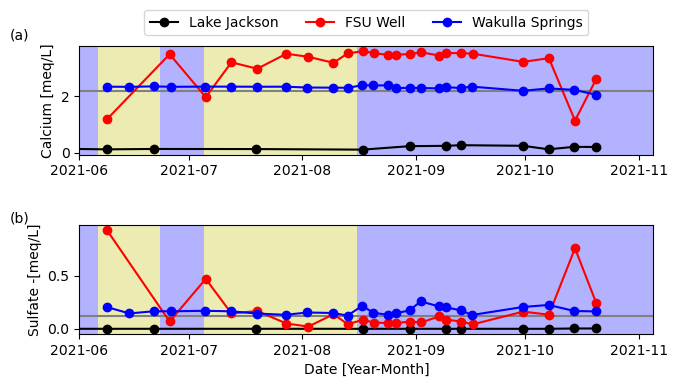

In [16]:
fig, ax = plt.subplots(2,1, figsize=(7,4))
fig.tight_layout(pad=3.0)

## Calcium Plot

ax[0].axhline(y=44/40.078*2, color= 'gray')
line1=ax[0].plot(LJ.index, LJ.Ca_meqL,'-o',color='k', label="Lake Jackson")
line2=ax[0].plot(FW.index, FW.Ca_meqL,'-o',color='r', label="FSU Well")
line3=ax[0].plot(WS.index, WS.Ca_meqL,'-o',color='b', label="Wakulla Springs")
ax[0].axvspan('2021-06-01','2021-06-06' ,facecolor='#b3b2fe')
ax[0].axvspan('2021-06-06', '2021-06-23',facecolor='#ecebb2')
ax[0].axvspan('2021-06-23', '2021-07-05',facecolor='#b3b2fe')
ax[0].axvspan('2021-07-05', '2021-08-16',facecolor='#ecebb2')
ax[0].axvspan('2021-08-16','2021-11-16' ,facecolor='#b3b2fe')
ax[0].set_xlim(left=datetime.date(2021,6,1), right=datetime.date(2021,11,5))

ax[0].set_ylabel("Calcium [meq/L]")

ax[0].legend(ncols=3,bbox_to_anchor=(0.5,1.4), loc="upper center")
ax[0].text(18760,4, "(a)")

## Sulfate Plot
ax[1].axhline(5.77/96.06*2, color='gray')
ax[1].plot(LJ.index, abs(LJ.SO4_meqL),'-o',color='k')
ax[1].plot(FW.index, abs(FW.SO4_meqL),'-o',color='r')
ax[1].plot(WS.index, abs(WS.SO4_meqL),'-o',color='b')
ax[1].axvspan('2021-06-01','2021-06-06' ,facecolor='#b3b2fe')
ax[1].axvspan('2021-06-06', '2021-06-23',facecolor='#ecebb2')
ax[1].axvspan('2021-06-23', '2021-07-05',facecolor='#b3b2fe')
ax[1].axvspan('2021-07-05', '2021-08-16',facecolor='#ecebb2')
ax[1].axvspan('2021-08-16','2021-11-16' ,facecolor='#b3b2fe')
ax[1].set_xlim(left=datetime.date(2021,6,1), right=datetime.date(2021,11,5))

ax[1].set_ylabel("Sulfate -[meq/L]")
ax[1].set_xlabel("Date [Year-Month]")
ax[1].text(18760,1, "(b)")
## Sulfate Plot
#ax[2].plot(LJ.index, LJ.Fluoride,'-o',color='k')ax[2].plot(FW.index, FW.Fluoride,'-o',color='r')
#ax[2].plot(WS.index, WS.Fluoride,'-o',color='b')
#ax[2].axvspan('2021-06-01','2021-06-06' ,facecolor='b', alpha=0.3)
#ax[2].axvspan('2021-06-06', '2021-06-23',facecolor='y', alpha=0.3)
#ax[2].axvspan('2021-06-23', '2021-07-05',facecolor='b', alpha=0.3)
#ax[2].axvspan('2021-07-05', '2021-08-16',facecolor='y', alpha=0.3)
#ax[2].axvspan('2021-08-16','2021-11-16' ,facecolor='b', alpha=0.3)
#ax[2].set_xlim(left=datetime.date(2021,6,1), right=datetime.date(2021,11,5))

#ax[2].set_ylabel("Fluoride [ppm]")
#ax[2].set_xlabel("Date [Year-Month]")


#ax[2].axvspan('2021-06-01','2021-06-06' ,facecolor='#b3b2fe', alpha=0.9)
#ax[2].axvspan('2021-06-06', '2021-06-23',facecolor='#ecebb2')
#ax[2].axvspan('2021-06-23', '2021-07-05',facecolor='#b3b2fe')
#ax[2].axvspan('2021-07-05', '2021-08-16',facecolor='#ecebb2')
#ax[2].axvspan('2021-08-16','2021-10-31' ,facecolor='#b3b2fe')

fig.savefig("../plots/WeeklyTimeseries.JPG", dpi=300, format='jpg')
fig.savefig("../plots/WeeklyTimeseries.EPS", dpi=300, format='eps')

In [17]:
feb_df=pd.read_csv("../data/processed/FSUWell_FebMar_meqL.csv")
feb_df=feb_df[3:28]
feb_df["Datatime_Collection"]=pd.to_datetime(feb_df["Datatime_Collection"])
feb_df

,Unnamed: 0,ID,Datatime_Collection,pH,EC,Na_meqL,NH4,K_meqL,Mg_meqL,Ca_meqL,...,Cl_meqL,Br_meqL,NO3_meqL,PO4_meqL,SO4_meqL,HCO3_meqL,CO3_meqL,CationSum,AnionSum,EB_perc
3,3,FW101,2022-02-03 17:20:00,6.83,201.0,0.867,0.070,0.137,0.160,1.420,...,-0.247,-0.001,-0.132,-0.041,-0.926,-0.471,-0.000,2.584,-1.776,18.53
4,4,FW102,2022-02-04 10:45:00,7.13,211.0,0.882,0.066,0.130,0.174,1.641,...,-0.259,-0.001,-0.132,-0.048,-0.931,-0.601,-0.001,2.827,-1.923,19.03
5,5,FW103,2022-02-05 12:10:00,8.21,252.0,0.754,0.050,0.107,0.218,2.449,...,-0.257,-0.001,-0.100,-0.039,-0.699,-1.329,-0.018,3.528,-2.385,19.33
6,6,FW104,2022-02-06 18:40:00,7.72,294.0,0.485,0.025,0.063,0.277,3.328,...,-0.192,-0.001,-0.064,-0.026,-0.396,-2.291,-0.011,4.153,-2.943,17.05
7,7,FW105,2022-02-07 13:40:00,7.64,298.0,0.344,0.012,0.036,0.358,4.512,...,-0.174,-0.001,-0.038,-0.019,-0.186,-2.703,-0.010,5.250,-3.101,25.73
8,8,FW106,2022-02-08 11:40:00,7.62,319.0,0.286,0.006,0.047,0.349,4.283,...,-0.157,-0.001,-0.026,-0.015,-0.100,-3.030,-0.011,4.965,-3.313,19.96
9,9,FW107,2022-02-09 16:00:00,7.71,308.0,0.263,0.009,0.003,0.321,3.876,...,-0.149,-0.001,-0.026,-0.014,-0.110,-2.860,-0.013,4.463,-3.145,17.32
10,10,FW108,2022-02-10 11:20:00,7.69,318.0,0.254,0.000,0.021,0.350,4.268,...,-0.151,-0.001,-0.026,-0.011,-0.076,-3.020,-0.013,4.893,-3.273,19.84
11,11,FW109,2022-02-11 10:45:00,7.66,326.0,0.232,0.000,0.021,0.339,4.175,...,-0.139,-0.001,-0.022,-0.013,-0.073,-3.085,-0.012,4.767,-3.319,17.91
12,12,FW110,2022-02-12 15:20:00,7.58,338.0,0.272,0.000,0.028,0.385,5.013,...,-0.161,-0.001,-0.025,-0.017,-0.088,-3.270,-0.011,5.698,-3.544,23.31


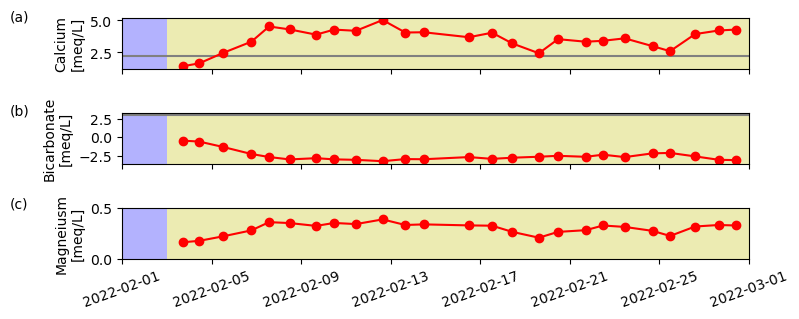

In [18]:
### CARBONATE SYSTEM IONS
### PLOT TIMESERIES OF INDIVIDUAL IONS AT DAILY SCALE
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(3,1, figsize=(7,3))
fig.tight_layout()

## Calcium Plot
ax[0].axhline(y=44/40.078*2, color= 'gray')

ax[0].plot(feb_df.Datatime_Collection, feb_df.Ca_meqL,'-o',color='r')
ax[0].axvspan('2022-01-30','2022-02-03' ,facecolor='#b3b2fe')
ax[0].axvspan('2022-02-03', '2022-03-02',facecolor='#ecebb2')
ax[0].set_xlim(left=datetime.date(2022,2,1), right=datetime.date(2022,3,1))

ax[0].set_ylabel("Calcium\n[meq/L]")
ax[0].set_xticklabels([])
ax[0].text(19019,5, "(a)")

## Bicarbonate Plot
ax[1].axhline(183.7/61.0168, color='gray')
#ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax[1].plot(feb_df['Datatime_Collection'], np.asarray(feb_df['HCO3_meqL'], float),'-o',color='r')
ax[1].tick_params(axis='x', labelrotation=20)
ax[1].set_xticklabels([])
ax[1].set_ylabel("Bicarbonate\n[meq/L]")
#ax[1].set_xticklabels([])
#ax[1].set_yticks([0, 30])

ax[1].axvspan('2022-01-30','2022-02-03' ,facecolor='#b3b2fe')
ax[1].axvspan('2022-02-03', '2022-03-02',facecolor='#ecebb2')
ax[1].set_xlim(left=datetime.date(2022,2,1), right=datetime.date(2022,3,1))
ax[1].text(19019,3, "(b)")
## MAgnsiumn Plot
ax[2].plot(feb_df.Datatime_Collection, feb_df.Mg_meqL,'-o',color='r')
ax[2].set_ylabel("Magneiusm\n[meq/L]")
ax[2].axvspan('2022-01-30','2022-02-03' ,facecolor='#b3b2fe')
ax[2].axvspan('2022-02-03', '2022-03-02',facecolor='#ecebb2')
ax[2].set_xlim(left=datetime.date(2022,2,1), right=datetime.date(2022,3,1))
ax[2].set_ylim(0,0.5)
ax[2].axhline(13/24.305*2, color='gray')
ax[2].tick_params(axis='x', labelrotation=20)
ax[2].text(19019,0.5, "(c)")
fig.savefig("../plots/DailyCarbonateTimeseries.JPG", dpi=300, format='jpg',bbox_inches="tight")
fig.savefig("../plots/DailyCarbonateTimeseries.EPS", dpi=300, format='eps',bbox_inches="tight")

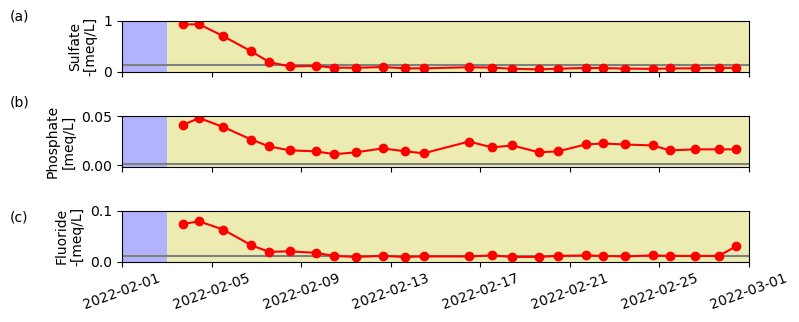

In [19]:
## HAWTHORN GROUP MINERALS

### PLOT TIMESERIES OF INDIVIDUAL IONS AT DAILY SCALE

fig, ax = plt.subplots(3,1, figsize=(7,3))
fig.tight_layout()

## Sulfate Plot
ax[0].axhline(5.77/96.06*2, color='gray')
ax[0].plot(feb_df.Datatime_Collection, abs(feb_df.SO4_meqL),'-o',color='r')
ax[0].axvspan('2022-01-30','2022-02-03' ,facecolor='#b3b2fe')
ax[0].axvspan('2022-02-03', '2022-03-02',facecolor='#ecebb2')
ax[0].set_xlim(left=datetime.date(2022,2,1), right=datetime.date(2022,3,1))
ax[0].set_ylabel("Sulfate\n-[meq/L]")
ax[0].set_ylim(0,1)
ax[0].set_xticklabels([])
ax[0].text(19019,1, "(a)")

ax[1].axhline(0.027/94.9714*3, color='gray')
ax[1].plot(feb_df.Datatime_Collection, abs(feb_df.PO4_meqL),'-o',color='r')
ax[1].tick_params(axis='x', labelrotation=20)
ax[1].set_ylabel("Phosphate\n[meq/L]")
ax[1].set_xticklabels([])

ax[1].axvspan('2022-01-30','2022-02-03' ,facecolor='#b3b2fe')
ax[1].axvspan('2022-02-03', '2022-03-02',facecolor='#ecebb2')
ax[1].set_xlim(left=datetime.date(2022,2,1), right=datetime.date(2022,3,1))
#ax[1].set_ylim(0,0.075)
ax[1].text(19019,0.06, "(b)")

ax[2].axhline(0.2/18.998, color='gray')
ax[2].plot(feb_df.Datatime_Collection, abs(feb_df.F_meqL),'-o',color='r')

ax[2].set_ylabel("Fluoride\n-[meq/L]")
ax[2].axvspan('2022-01-30','2022-02-03' ,facecolor='#b3b2fe')
ax[2].axvspan('2022-02-03', '2022-03-02',facecolor='#ecebb2')
ax[2].set_xlim(left=datetime.date(2022,2,1), right=datetime.date(2022,3,1))
ax[2].set_ylim(0,0.1)
ax[2].tick_params(axis='x', labelrotation=20)
ax[2].text(19019,0.08, "(c)")
fig.savefig("../plots/DailySilicateTimeseries.JPG", dpi=300, format='jpg',bbox_inches="tight")
fig.savefig("../plots/DailySilicateTimeseries.EPS", dpi=300, format='eps',bbox_inches="tight")

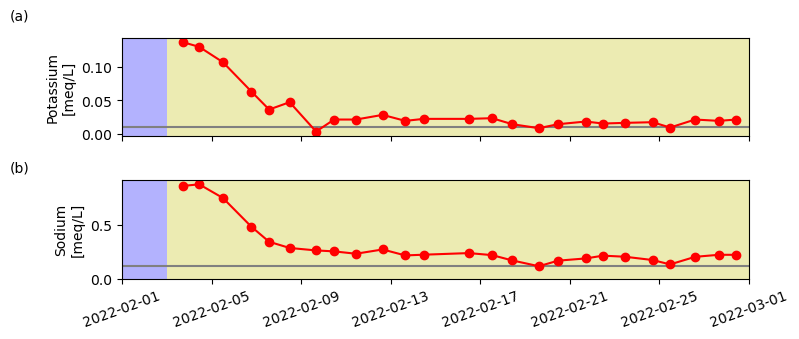

In [20]:
## HAWTHORN GROUP MINERALS

### PLOT TIMESERIES OF INDIVIDUAL IONS AT DAILY SCALE

fig, ax = plt.subplots(2,1, figsize=(7,3))
fig.tight_layout()

## Potassium Plot
ax[0].axhline(0.367/39.098, color='gray')
ax[0].plot(feb_df.Datatime_Collection, feb_df.K_meqL,'-o',color='r')
ax[0].axvspan('2022-01-30','2022-02-03' ,facecolor='#b3b2fe')
ax[0].axvspan('2022-02-03', '2022-03-02',facecolor='#ecebb2')
ax[0].set_xlim(left=datetime.date(2022,2,1), right=datetime.date(2022,3,1))
ax[0].set_ylabel("Potassium\n[meq/L]")
ax[0].set_xticklabels([])
ax[0].text(19019,0.17, "(a)")


# Sodium Plot
ax[1].axhline(2.7/22.990, color='gray')
ax[1].plot(feb_df.Datatime_Collection, feb_df.Na_meqL,'-o',color='r')

ax[1].set_ylabel("Sodium\n[meq/L]")
ax[1].axvspan('2022-01-30','2022-02-03' ,facecolor='#b3b2fe')
ax[1].axvspan('2022-02-03', '2022-03-02',facecolor='#ecebb2')
ax[1].set_xlim(left=datetime.date(2022,2,1), right=datetime.date(2022,3,1))
ax[1].set_ylim(0,)
ax[1].tick_params(axis='x', labelrotation=20)
ax[1].text(19019,1, "(b)")
fig.savefig("../plots/DailyKNaTimeseries.JPG", dpi=300, format='jpg',bbox_inches="tight")
fig.savefig("../plots/DailyKNaTimeseries.EPS", dpi=300, format='eps',bbox_inches="tight")

In [21]:
WQChartPy_df

,Sample,Label,Color,Marker,Size,Alpha,pH,Ca,Mg,Na,K,HCO3,Cl,CO3,SO4,TDS
0,LJ000,Lake Jackson,k,o,30,0.9,6.520,3.560,1.812,2.440,1.077,16.8371,5.9191,0.0026,0.0000,36.47
1,LJ002,Lake Jackson,k,o,30,0.9,6.550,2.393,0.966,1.818,0.949,7.3283,4.6700,0.0012,0.0000,22.40
2,LJ003,Lake Jackson,k,o,30,0.9,5.990,2.460,1.023,2.275,0.733,8.8397,3.8784,0.0004,0.0000,24.50
3,LJ004,Lake Jackson,k,o,30,0.9,6.310,2.656,1.197,2.439,0.778,11.9755,3.8762,0.0011,0.0000,26.60
4,LJ005,Lake Jackson,k,o,30,0.9,6.120,3.499,1.543,4.056,2.849,13.3341,5.0591,0.0008,0.0000,41.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,WS021,Wakulla Springs,b,o,30,0.9,7.490,46.775,9.562,5.250,0.627,166.6633,3.7756,0.2375,6.2653,213.50
72,WS022,Wakulla Springs,b,o,30,0.9,7.370,43.847,9.294,5.086,0.550,159.3637,7.1763,0.1723,9.9069,205.10
73,WS023,Wakulla Springs,b,o,30,0.9,7.980,45.501,9.189,5.141,0.558,166.2267,7.2922,0.7322,10.7847,209.30
74,WS024,Wakulla Springs,b,o,30,0.9,7.485,44.493,9.435,4.705,0.642,161.1981,6.0072,0.2271,8.0690,203.70


Trilinear Piper plot created. Saving it to C:\Users\kylec\OneDrive - Florida State University\Documents\PhD\Research\Hydrochemcial_SinkholeDryDown\code 

Trilinear Piper plot created. Saving it to C:\Users\kylec\OneDrive - Florida State University\Documents\PhD\Research\Hydrochemcial_SinkholeDryDown\code 



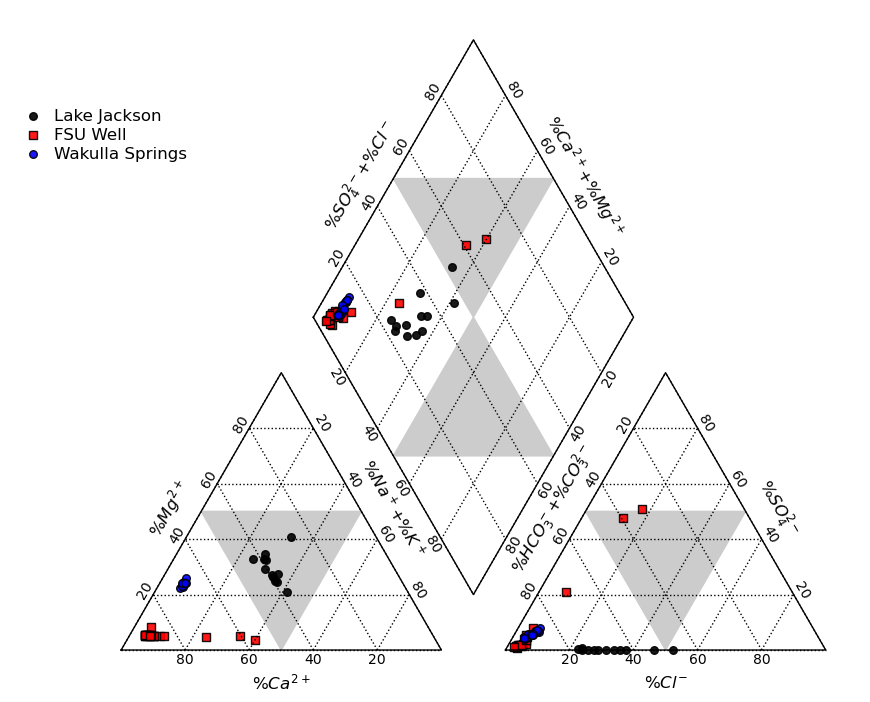

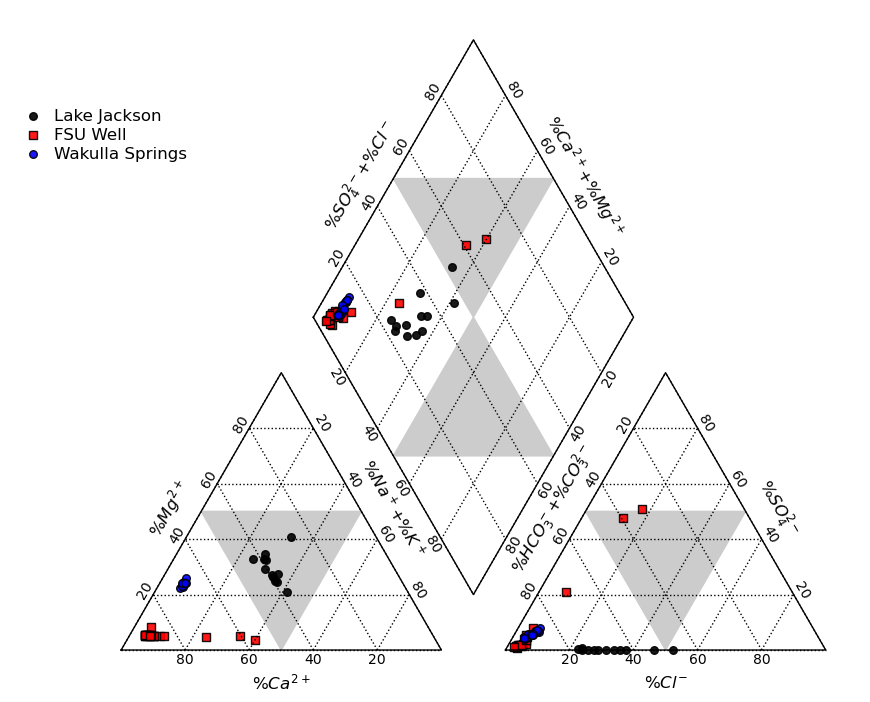

In [22]:
from wqchartpy import triangle_piper

WQChartPy_df=WQChartPy_df.drop(WQChartPy_df[WQChartPy_df.Sample.isin(drop_rows_list)].index.tolist())
WQChartPy_df=WQChartPy_df.reset_index(inplace=False)
# Draw the diagram and save it to the plots folder in both SVG and jpg formats
triangle_piper.plot(WQChartPy_df, unit='mg/L', figname='../plots/WeeklyPiper', figformat='jpg')
triangle_piper.plot(WQChartPy_df, unit='mg/L', figname='../plots/WeeklyPiper', figformat='svg')

Gaillardet plot created. Saving it to C:\Users\kylec\OneDrive - Florida State University\Documents\PhD\Research\Hydrochemcial_SinkholeDryDown\code 

Gaillardet plot created. Saving it to C:\Users\kylec\OneDrive - Florida State University\Documents\PhD\Research\Hydrochemcial_SinkholeDryDown\code 



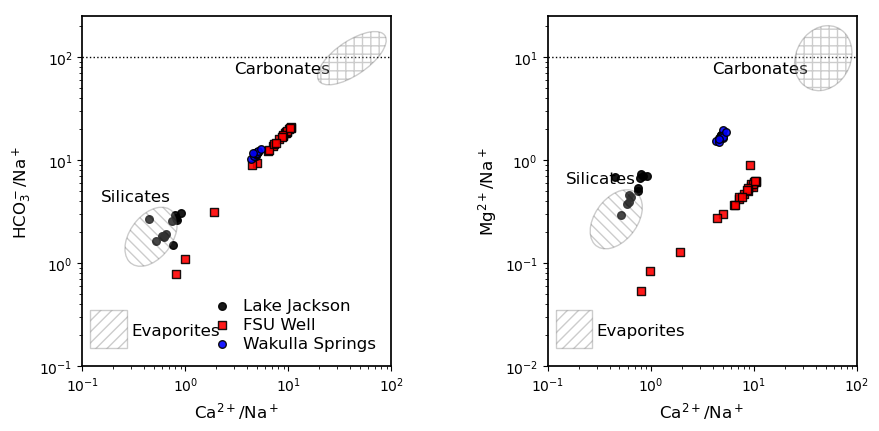

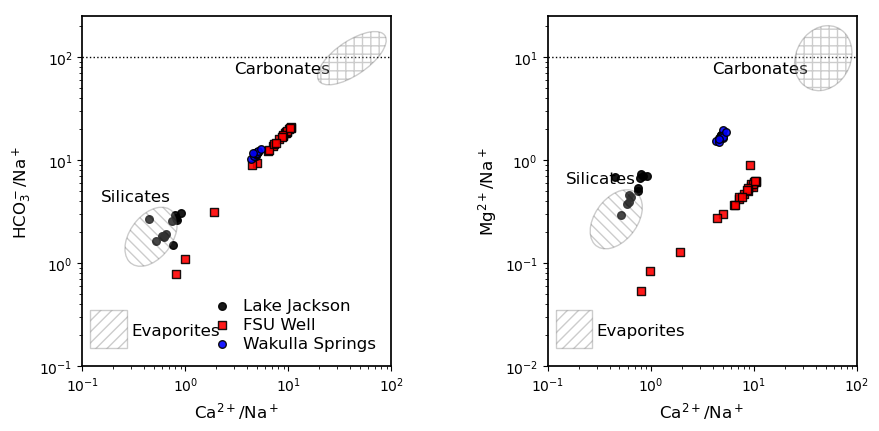

In [23]:
from wqchartpy import gaillardet; 

gaillardet.plot(WQChartPy_df, unit='mg/L', figname='../plots/WeeklyGaillardet', figformat='jpg')
gaillardet.plot(WQChartPy_df, unit='mg/L', figname='../plots/WeeklyGaillardet', figformat='svg')

## Read in the Daily scale sampling data that was collected in February 2022

In [24]:
##Daily Scale
FWD = pd.read_csv('../data/processed/FSUWell_FebMar_WQ.csv', parse_dates=['Datatime_Collection'])
FWD

,Unnamed: 0,ID,Datatime_Collection,Li,Na,NH4,K,Mg,Ca,F,...,TDS,pH,pOH,TotalAlk(mg/L_asCaCO3),Fe,Temp,H,OH,CO3,HCO3
0,0,FW100A,NaT,0,20.554,1.313,4.8590,2.124,30.762,1.3080,...,149.10,6.93,7.07,29.2,NaN,22.0,0.000118,0.001448,0.013115,35.578316
1,1,FW100B,NaT,0,19.351,1.190,4.4000,2.291,38.636,1.2288,...,162.40,7.33,6.67,46.2,NaN,22.0,0.000047,0.003636,0.052053,56.214746
2,2,FW100C,NaT,0,23.277,1.383,5.4860,2.216,34.128,1.3143,...,143.50,7.19,6.81,27.5,NaN,21.9,0.000065,0.002634,0.022409,33.479152
3,3,FW101,2022-02-03 17:20:00,0,19.929,1.255,5.3470,1.940,28.456,1.4120,...,140.70,6.83,7.17,23.6,0.220,20.5,0.000149,0.001150,0.008147,28.763370
4,4,FW102,2022-02-04 10:45:00,0,20.288,1.197,5.1000,2.117,32.874,1.5083,...,147.70,7.13,6.87,30.1,0.090,19.7,0.000075,0.002294,0.020340,36.655295
5,5,FW103,2022-02-05 12:10:00,0,17.335,0.894,4.1830,2.651,49.071,1.2057,...,176.40,8.21,5.79,67.5,0.087,20.7,0.000006,0.027583,0.553350,81.077613
6,6,FW104,2022-02-06 18:40:00,0,11.149,0.454,2.4660,3.369,66.684,0.6093,...,205.80,7.72,6.28,115.2,0.330,21.9,0.000019,0.008926,0.317039,139.785609
7,7,FW105,2022-02-07 13:40:00,0,7.909,0.209,1.4090,4.350,90.422,0.3530,...,208.60,7.64,6.36,135.8,0.000,21.3,0.000023,0.007424,0.307054,164.928731
8,8,FW106,2022-02-08 11:40:00,0,6.577,0.103,1.8280,4.240,85.823,0.3840,...,223.30,7.62,6.38,152.2,0.000,21.1,0.000024,0.007090,0.327258,184.885121
9,9,FW107,2022-02-09 16:00:00,0,6.049,0.156,0.1325,3.903,77.680,0.3223,...,215.60,7.71,6.29,143.8,0.163,21.9,0.000020,0.008722,0.386800,174.515944


In [25]:
format_df2 = pd.DataFrame()

format_df2['Sample'] = FWD['ID']
format_df2['Label'] = 'Daily FSU Well'
format_df2['Color']='r'
format_df2['Marker']='s'
format_df2['Size']=30
format_df2['Alpha']=0.9
format_df2['pH'] = FWD['pH']
format_df2['Ca'] = FWD['Ca']
format_df2['Mg'] = FWD['Mg']
format_df2['Na'] = FWD['Na']              
format_df2['K'] = FWD['K']   
format_df2['HCO3'] = FWD['HCO3']
format_df2['Cl'] = FWD['Cl']
format_df2['CO3']= FWD['CO3']
format_df2['SO4'] = FWD['SO4'].values
format_df2['TDS'] = FWD['EC']*0.7
#format_df['Day']= wq_df['Sampling time'].dt.dayofyear-124
format_df2
format_df2.drop(format_df2.tail(3).index,inplace=True) # drop last n rows


Trilinear Piper plot created. Saving it to C:\Users\kylec\OneDrive - Florida State University\Documents\PhD\Research\Hydrochemcial_SinkholeDryDown\code 

Trilinear Piper plot created. Saving it to C:\Users\kylec\OneDrive - Florida State University\Documents\PhD\Research\Hydrochemcial_SinkholeDryDown\code 



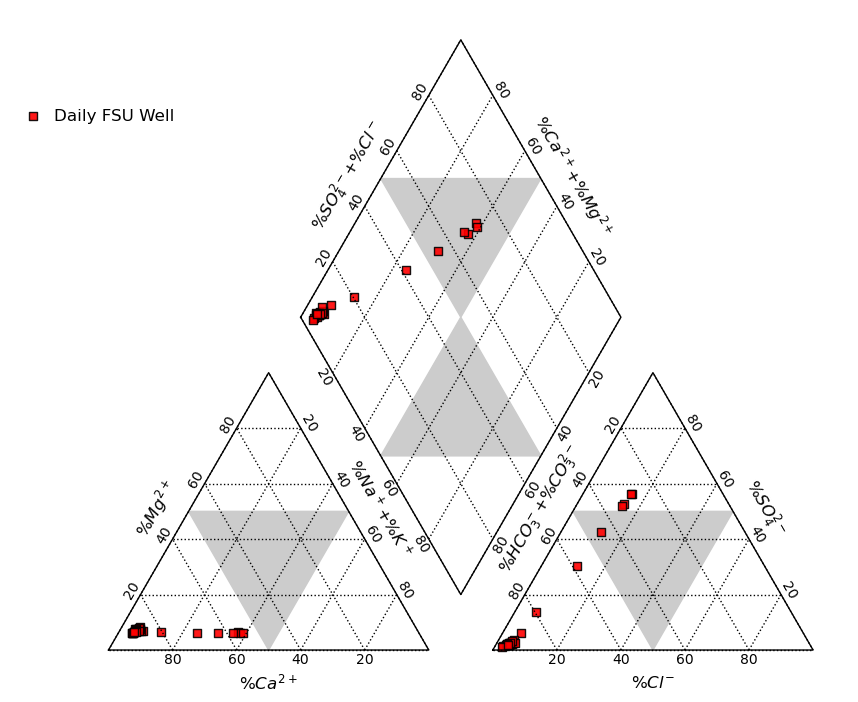

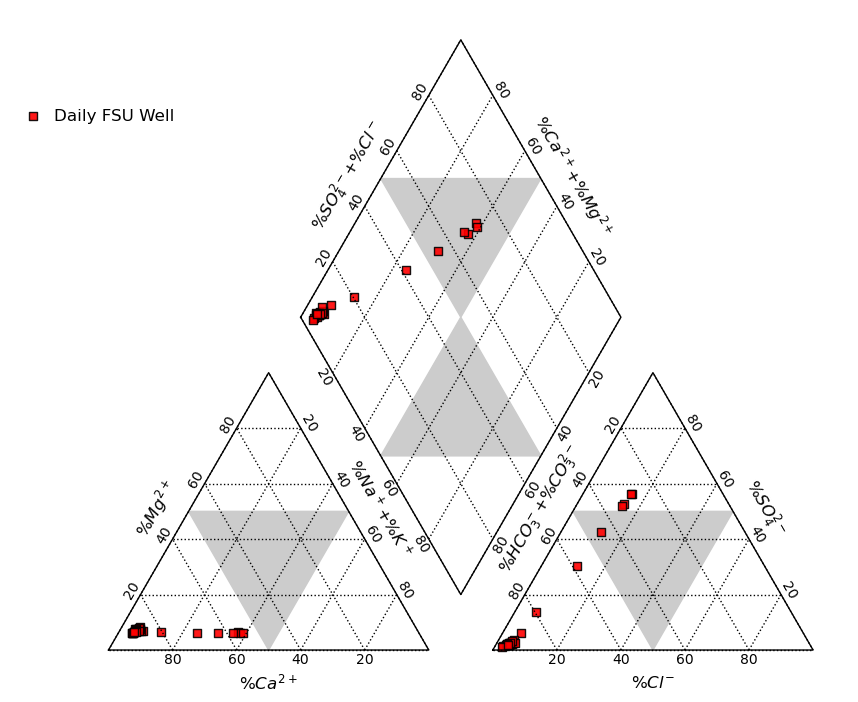

In [26]:
from wqchartpy import triangle_piper

# Draw the diagram
triangle_piper.plot(format_df2, unit='mg/L', figname='../plots/PiperDaily', figformat='jpg')
triangle_piper.plot(format_df2, unit='mg/L', figname='../plots/PiperDaily', figformat='SVG')

Gaillardet plot created. Saving it to C:\Users\kylec\OneDrive - Florida State University\Documents\PhD\Research\Hydrochemcial_SinkholeDryDown\code 

Gaillardet plot created. Saving it to C:\Users\kylec\OneDrive - Florida State University\Documents\PhD\Research\Hydrochemcial_SinkholeDryDown\code 



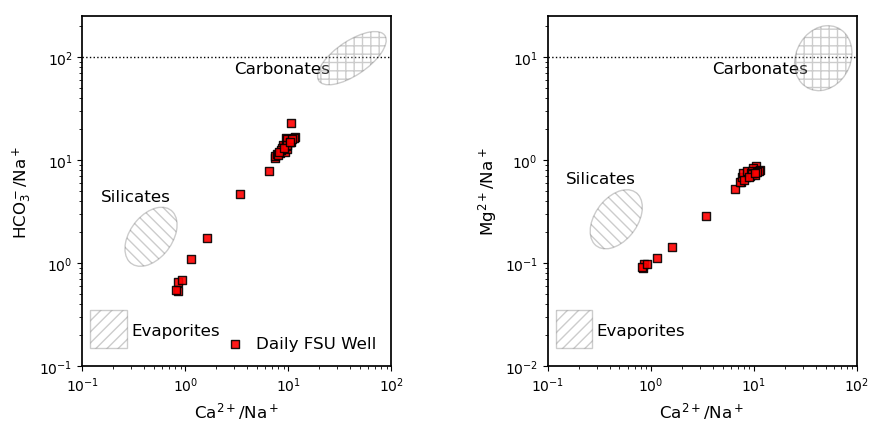

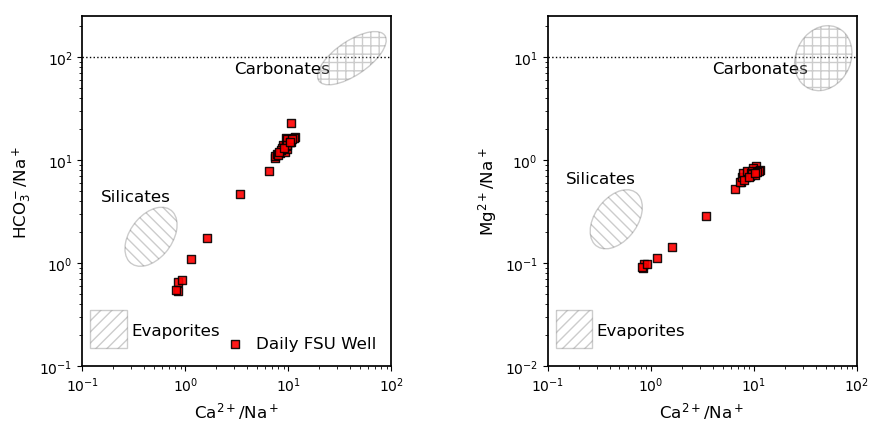

In [27]:
from wqchartpy import gaillardet;
gaillardet.plot(format_df2, unit='mg/L', figname='../plots/GaillardetDaily', figformat='svg')
gaillardet.plot(format_df2, unit='mg/L', figname='../plots/GaillardetDaily', figformat='jpg')

## COMPARE 2021 and 2022 DATA

TtestResult(statistic=-1.7772368673670522, pvalue=0.08223215813379695, df=45.37794059733509)
RanksumsResult(statistic=-2.177264142951197, pvalue=0.029460864910109456)


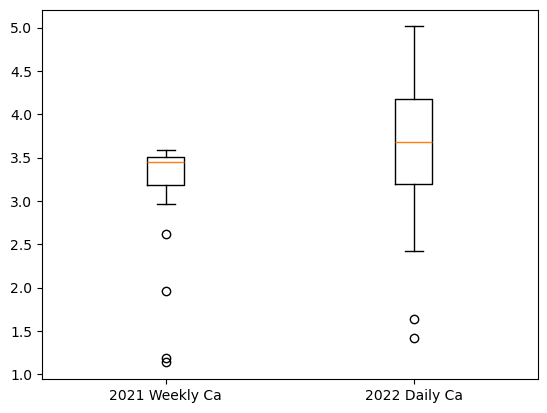

In [64]:
Ca_box = [FW['Ca_meqL'], feb_df['Ca_meqL']]
Mg_box = [FW['Mg_meqL'], feb_df['Mg_meqL']]
Na_box = [FW['Na_meqL'], feb_df['Na_meqL']]
K_box = [FW['K_meqL'], feb_df['K_meqL']]
HCO3_box = [FW['HCO3_meqL'], feb_df['HCO3_meqL']]
Cl_box = [FW['Cl_meqL'], feb_df['Cl_meqL']]
SO4_box = [FW['SO4_meqL'], feb_df['SO4_meqL']]



plt.boxplot(Ca_box, labels = ["2021 Weekly Ca", "2022 Daily Ca"])
print(scipy.stats.ttest_ind(Ca_box[0],Ca_box[1], equal_var = False))
print(scipy.stats.ranksums(Ca_box[0],Ca_box[1]))

TtestResult(statistic=-6.620422342107069, pvalue=3.633770084048191e-08, df=45.27194747099416)
RanksumsResult(statistic=-4.622816758493538, pvalue=3.7856410954994944e-06)


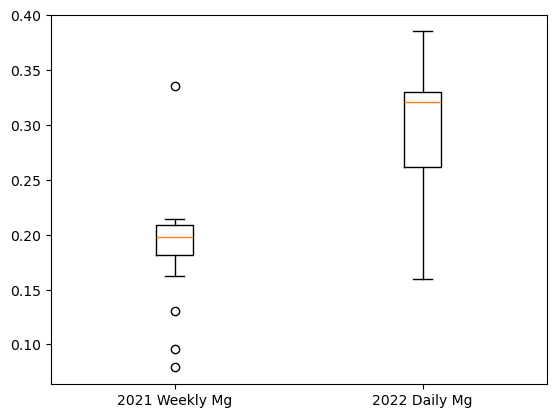

In [66]:
plt.boxplot(Mg_box, labels = ["2021 Weekly Mg", "2022 Daily Mg"])
print(scipy.stats.ttest_ind(Mg_box[0],Mg_box[1], equal_var = False))
print(scipy.stats.ranksums(Mg_box[0],Mg_box[1]))

TtestResult(statistic=-0.8003660053250052, pvalue=0.42793488476663877, df=42.647748439363)
RanksumsResult(statistic=-1.0318787407351646, pvalue=0.30212892624113963)


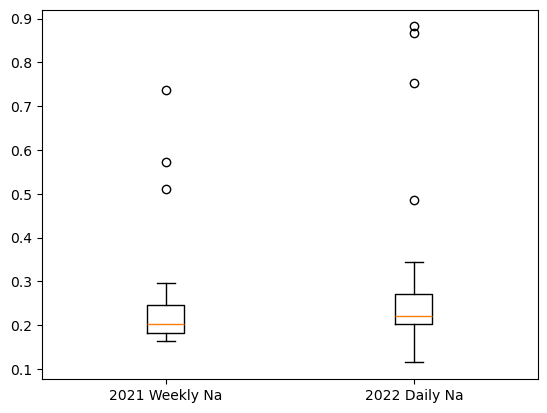

In [67]:
plt.boxplot(Na_box, labels = ["2021 Weekly Na", "2022 Daily Na"])
print(scipy.stats.ttest_ind(Na_box[0],Na_box[1], equal_var = False))
print(scipy.stats.ranksums(Na_box[0],Na_box[1]))

TtestResult(statistic=0.46943050508304324, pvalue=0.6409795528192288, df=45.9996927370025)
RanksumsResult(statistic=2.1050326310997356, pvalue=0.03528846771113008)


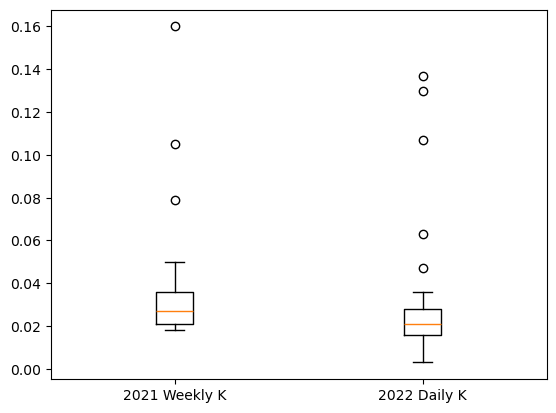

In [68]:
plt.boxplot(K_box, labels = ["2021 Weekly K", "2022 Daily K"])
print(scipy.stats.ttest_ind(K_box[0],K_box[1], equal_var = False))
print(scipy.stats.ranksums(K_box[0],K_box[1]))

TtestResult(statistic=0.31715491553247344, pvalue=0.752606769673371, df=44.57719073452432)
RanksumsResult(statistic=0.4540266459234724, pvalue=0.6498096484686378)


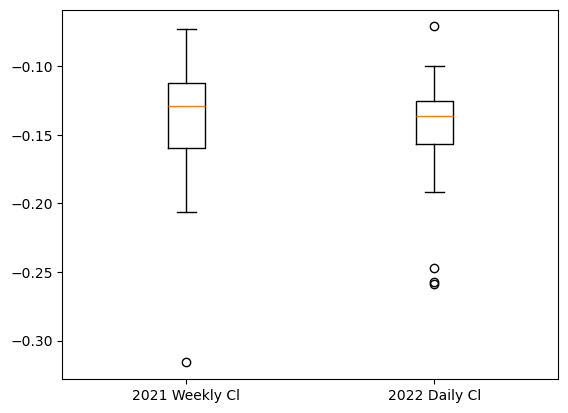

In [70]:
plt.boxplot(Cl_box, labels = ["2021 Weekly Cl", "2022 Daily Cl"])
print(scipy.stats.ttest_ind(Cl_box[0],Cl_box[1], equal_var = False))
print(scipy.stats.ranksums(Cl_box[0],Cl_box[1]))

TtestResult(statistic=-1.933134220192856, pvalue=0.05975852690293627, df=43.41248934957592)
RanksumsResult(statistic=-3.7457198288686473, pvalue=0.00017987725406094432)


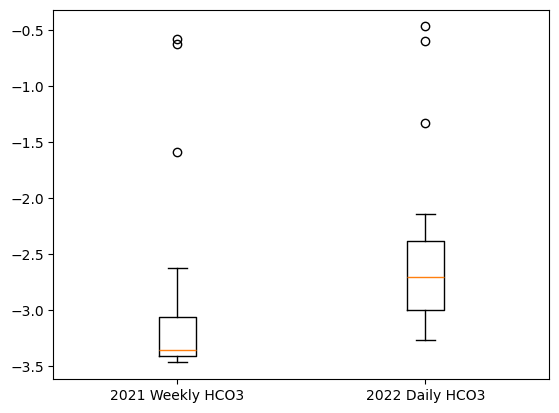

In [71]:
plt.boxplot(HCO3_box, labels = ["2021 Weekly HCO3", "2022 Daily HCO3"])
print(scipy.stats.ttest_ind(HCO3_box[0],HCO3_box[1], equal_var = False))
print(scipy.stats.ranksums(HCO3_box[0],HCO3_box[1]))

TtestResult(statistic=0.08914457214929185, pvalue=0.9293547873103513, df=45.90792425842194)
RanksumsResult(statistic=-0.12382544888821974, pvalue=0.9014534815806008)


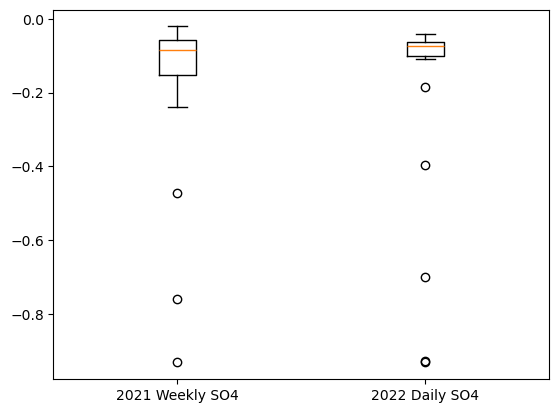

In [72]:
plt.boxplot(SO4_box, labels = ["2021 Weekly SO4", "2022 Daily SO4"])
print(scipy.stats.ttest_ind(SO4_box[0],SO4_box[1], equal_var = False))
print(scipy.stats.ranksums(SO4_box[0],SO4_box[1]))